In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [98]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the amino acid alphabet
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AA_TO_IDX = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}
IDX_TO_AA = {idx: aa for idx, aa in enumerate(AMINO_ACIDS)}

class ProteinDataset(Dataset):
    """
    Custom dataset class for protein sequences and their properties.
    
    This class handles the conversion from amino acid sequences to numerical
    representations and manages the relationship between sequences and their
    target properties.
    """
    
    def __init__(self, sequences, targets, max_length=500):
        # If sequences/targets are pandas Series – drop old index and convert
        if isinstance(sequences, pd.Series):
            sequences = sequences.reset_index(drop=True).tolist()
        if isinstance(targets, pd.Series):
            targets = targets.reset_index(drop=True).tolist()

        self.sequences = sequences          # now a simple Python list
        self.targets   = targets            # plain list as well
        self.max_length = max_length

        # Normalise targets
        self.target_scaler = StandardScaler()
        self.normalized_targets = self.target_scaler.fit_transform(
            np.array(self.targets).reshape(-1, 1)
        ).flatten()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        target   = self.normalized_targets[idx]

        sequence_tensor = self.sequence_to_tensor(sequence)
        target_tensor   = torch.tensor(target, dtype=torch.float32)
        return sequence_tensor, target_tensor
    
    def sequence_to_tensor(self, sequence):
        """
        Convert a protein sequence string to a one-hot encoded tensor.
        
        This function handles padding and truncation to ensure all sequences
        have the same length.
        """
        # Truncate if too long
        if len(sequence) > self.max_length:
            sequence = sequence[:self.max_length]
        
        # Create one-hot encoding
        tensor = torch.zeros(self.max_length, len(AMINO_ACIDS))
        
        for i, aa in enumerate(sequence):
            if aa in AA_TO_IDX:
                tensor[i, AA_TO_IDX[aa]] = 1.0
        
        return tensor
    
    def denormalize_target(self, normalized_value):
        """
        Convert normalized target back to original scale.
        
        This is useful for interpreting model predictions.
        """
        return self.target_scaler.inverse_transform([[normalized_value]])[0][0]

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProteinCNN(nn.Module):
    """
    An intermediate CNN that balances complexity and regularization.
    - Restores one deeper convolutional layer to capture hierarchical patterns.
    - Uses a moderately sized fully-connected head.
    """ 

    def __init__(self, num_amino_acids=21, embedding_dim=64, num_filters=96, dropout_rate=0.4):
        """
        Initialize the intermediate CNN architecture.
        
        Args:
            num_amino_acids: Vocabulary size (e.g., 20 + 1 for padding).
            embedding_dim: Size of the learned embedding vector.
            num_filters: Number of filters. Increased slightly to 96 to give more capacity.
            dropout_rate: A more moderate dropout rate.
        """
        super(ProteinCNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=num_amino_acids, embedding_dim=embedding_dim)

        # First block of convolutions with different kernel sizes
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=1, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=3)

        self.batch_norm1 = nn.BatchNorm1d(num_filters)
        self.batch_norm2 = nn.BatchNorm1d(num_filters)
        self.batch_norm3 = nn.BatchNorm1d(num_filters)

        # --- RESTORED a deeper convolutional layer ---
        # This allows the model to learn combinations of the initial motifs.
        # It takes the concatenated output (num_filters * 3) as input.
        self.conv4 = nn.Conv1d(num_filters * 3, num_filters * 2, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(num_filters * 2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # --- FC head is more powerful than before, but simpler than original ---
        # The input is from conv4, which has num_filters * 2 channels.
        self.fc1 = nn.Linear(num_filters * 2, 64) 
        self.fc_out = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_one_hot):
        """
        Forward pass.
        
        Args:
            x_one_hot: Input tensor of one-hot vectors [batch, seq_len, num_amino_acids]
        """
        # Convert one-hot to indices on the fly
        x_indices = torch.argmax(x_one_hot, dim=2)
        
        x = self.embedding(x_indices)
        x = x.transpose(1, 2)
        
        # First conv block
        conv1_out = F.relu(self.batch_norm1(self.conv1(x)))
        conv2_out = F.relu(self.batch_norm2(self.conv2(x)))
        conv3_out = F.relu(self.batch_norm3(self.conv3(x)))
        
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)
        
        # --- Apply the deeper conv layer ---
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.dropout(x) # Apply dropout after the main conv blocks
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc_out(x)
        
        return x

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from fpgen.prop_prediction.metrics import get_regression_metrics
import time

# Set random seeds for reproducibility
# This ensures that your results are consistent across runs
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

Training on: cuda


In [102]:
import tqdm


def train_cnn_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """
    Train the CNN model with careful monitoring and early stopping.
    
    This function implements best practices for training neural networks on small datasets,
    including learning rate scheduling, early stopping, and comprehensive monitoring.
    """
    print(torch.cuda.device_count())
    torch.cuda.set_device(0)
    # Move model to the appropriate device (GPU if available)
    model = model.to(device)
    # print devices
    
    
    # Choose optimizer and loss function
    # Adam is generally a good choice for CNNs because it adapts the learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Mean Squared Error for regression tasks
    criterion = nn.MSELoss()
    
    # Learning rate scheduler - reduces learning rate when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=10, factor=0.5
    )
    
    # Early stopping to prevent overfitting
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 20
    
    # Track training history
    train_losses = []
    val_losses = []
    learning_rates = []
    
    print("Starting training...")
    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Validation batches per epoch: {len(val_loader)}")
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        # Training phase
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_batches = 0
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            # Move data to device
            sequences = sequences.to(device)
            targets = targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(sequences)
            
            # Calculate loss
            loss = criterion(predictions.squeeze(), targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update parameters
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        # Calculate average training loss
        avg_train_loss = train_loss / train_batches
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():  # Disable gradient computation for efficiency
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                predictions = model(sequences)
                loss = criterion(predictions.squeeze(), targets)
                
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        
        # Record history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')
        print('-' * 50)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            print(f'New best model saved with validation loss: {best_val_loss:.6f}')
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_cnn_model.pth'))
    
    return model, train_losses, val_losses, learning_rates

In [103]:
def setup_data_loaders(fpbase_dataset, target_name='ex_max', batch_size=32, val_split=0.2):
    """
    Create training and validation data loaders using FPbase's train/test split.
    
    Args:
        fpbase_dataset: Instance of FPbase class
        target_name: Name of the target property (e.g., 'ex_max')
        batch_size: Batch size for DataLoader
        val_split: Fraction of training data to use for validation
    
    Returns:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        train_dataset: ProteinDataset instance for training data
    """
    
    # Get train and test data from FPbase
    x_train, y_train = fpbase_dataset.get_train(target_name, is_scaled=True)
    x_test, y_test = fpbase_dataset.get_test(target_name, is_scaled=True)
    
    # Create full training dataset
    train_full_dataset = ProteinDataset(x_train, y_train, max_length=500)
    
    # Split training data into train and validation
    total_size = len(train_full_dataset)
    train_size = int((1 - val_split) * total_size)
    val_size = total_size - train_size
    
    print(f"Full training set size: {total_size}")
    print(f"Training set size: {train_size}")
    print(f"Validation set size: {val_size}")
    print(f"Test set size: {len(x_test)}")
    
    # Split training dataset into train and validation
    train_dataset, val_dataset = random_split(
        train_full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Create test dataset
    test_dataset = ProteinDataset(x_test, y_test, max_length=500)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, val_loader, test_loader, train_full_dataset

In [104]:
def evaluate_model(model, data_loader, dataset, fpbase_dataset, target_name='ex_max'):
    """
    Evaluate the trained model and calculate performance metrics.
    
    This function provides comprehensive evaluation including predictions
    on both normalized and original scales using FPbase rescaling.
    
    Args:
        model: The trained model
        data_loader: DataLoader with test/validation data
        dataset: ProteinDataset instance
        fpbase_dataset: FPbase instance for proper rescaling
        target_name: Name of the target property (default: 'ex_max')
    """
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            predictions = model(sequences)
            
            all_predictions.extend(predictions.squeeze().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate metrics on normalized scale
    metrics_normalized = get_regression_metrics(all_predictions, all_targets)
    
    # Rescale using FPbase for interpretable metrics
    targets_original = fpbase_dataset.rescale_targets(all_targets, target_name)
    predictions_original = fpbase_dataset.rescale_targets(all_predictions, target_name)
    
    # Calculate metrics on original scale
    metrics_original = get_regression_metrics(predictions_original, targets_original)
    
    print("\nModel Evaluation Results:")
    print(f"Normalized metrics:")
    print(f"  R² Score: {metrics_normalized['r2']:.4f}")
    print(f"  RMSE: {metrics_normalized['rmse']:.4f}")
    print(f"  MAE: {metrics_normalized['mae']:.4f}")
    print(f"  Median AE: {metrics_normalized['mae_median']:.4f}")
    
    print(f"\nOriginal scale metrics:")
    print(f"  R² Score: {metrics_original['r2']:.4f}")
    print(f"  RMSE: {metrics_original['rmse']:.4f}")
    print(f"  MAE: {metrics_original['mae']:.4f}")
    print(f"  Median AE: {metrics_original['mae_median']:.4f}")
    
    return {
        'predictions_original': predictions_original,
        'targets_original': targets_original,
        **{f"{k}_original": v for k, v in metrics_original.items()},
        **{f"{k}_normalized": v for k, v in metrics_normalized.items()}
    }

def plot_training_history(train_losses, val_losses, learning_rates):
    """
    Visualize the training process to understand model behavior.
    
    These plots help you understand whether your model is learning properly,
    overfitting, or if you need to adjust hyperparameters.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training and validation losses
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot learning rate schedule
    axes[0, 1].plot(learning_rates, color='green')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate Schedule')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True)
    
    # Plot loss difference (overfitting indicator)
    loss_diff = np.array(val_losses) - np.array(train_losses)
    axes[1, 0].plot(loss_diff, color='purple')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Validation Loss - Training Loss')
    axes[1, 0].set_title('Overfitting Indicator')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].grid(True)
    
    # Plot validation loss with trend
    axes[1, 1].plot(val_losses, color='red', alpha=0.7)
    # Add trend line
    z = np.polyfit(range(len(val_losses)), val_losses, 1)
    p = np.poly1d(z)
    axes[1, 1].plot(range(len(val_losses)), p(range(len(val_losses))), 
                   color='black', linestyle='--', label='Trend')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Loss')
    axes[1, 1].set_title('Validation Loss with Trend')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [105]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [106]:
# Initialize FPbase dataset
from fpgen.prop_prediction.dataset import FPbase
dataset = FPbase()

# Create data loaders using FPbase's train/test split
batch_size = 32
train_loader, val_loader, test_loader, train_dataset = setup_data_loaders(
    fpbase_dataset=dataset,
    target_name='ex_max',
    batch_size=batch_size,
    val_split=0.2  # 20% of training data for validation
)

Full training set size: 676
Training set size: 540
Validation set size: 136
Test set size: 173


In [107]:
import torch
print("CUDA available :", torch.cuda.is_available())
print("GPU count       :", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} name     :", torch.cuda.get_device_name(i))
    print(f"GPU {i} capability:",
          torch.cuda.get_device_capability(i))

CUDA available : True
GPU count       : 1
GPU 0 name     : NVIDIA GeForce RTX 4050 Laptop GPU
GPU 0 capability: (8, 9)


In [112]:
# Initialize model
model = ProteinCNN(
    num_amino_acids=20,  # Standard amino acids
    num_filters=32,
    dropout_rate=0.5,
    embedding_dim=32
).to(device)

# Train model
print("Starting training...")
trained_model, train_losses, val_losses, learning_rates = train_cnn_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=500,
    learning_rate=0.001
)

Starting training...
1
Starting training...
Training batches per epoch: 17
Validation batches per epoch: 5


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Batch 0, Loss: 0.962449
Epoch 1, Batch 10, Loss: 1.238804


  0%|          | 1/500 [00:01<10:07,  1.22s/it]

Epoch 1/500:
  Train Loss: 1.026274
  Val Loss: 0.776575
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.776575
Epoch 2, Batch 0, Loss: 0.576295
Epoch 2, Batch 10, Loss: 0.763608


  0%|          | 2/500 [00:02<09:02,  1.09s/it]

Epoch 2/500:
  Train Loss: 0.909078
  Val Loss: 0.679759
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.679759
Epoch 3, Batch 0, Loss: 0.820835
Epoch 3, Batch 10, Loss: 0.949121


  1%|          | 3/500 [00:03<08:46,  1.06s/it]

Epoch 3/500:
  Train Loss: 0.772466
  Val Loss: 0.543945
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.543945
Epoch 4, Batch 0, Loss: 0.665565
Epoch 4, Batch 10, Loss: 0.611109


  1%|          | 4/500 [00:04<08:32,  1.03s/it]

Epoch 4/500:
  Train Loss: 0.686857
  Val Loss: 0.473288
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.473288
Epoch 5, Batch 0, Loss: 0.534586
Epoch 5, Batch 10, Loss: 0.635478


  1%|          | 5/500 [00:05<08:22,  1.01s/it]

Epoch 5/500:
  Train Loss: 0.685470
  Val Loss: 0.464612
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.464612
Epoch 6, Batch 0, Loss: 0.690639
Epoch 6, Batch 10, Loss: 0.618076


  1%|          | 6/500 [00:06<08:20,  1.01s/it]

Epoch 6/500:
  Train Loss: 0.667565
  Val Loss: 0.464299
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.464299
Epoch 7, Batch 0, Loss: 0.614269
Epoch 7, Batch 10, Loss: 0.685495


  1%|▏         | 7/500 [00:07<08:17,  1.01s/it]

Epoch 7/500:
  Train Loss: 0.612707
  Val Loss: 0.474403
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 8, Batch 0, Loss: 0.420815
Epoch 8, Batch 10, Loss: 1.045979


  2%|▏         | 8/500 [00:08<08:13,  1.00s/it]

Epoch 8/500:
  Train Loss: 0.605115
  Val Loss: 0.694783
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 9, Batch 0, Loss: 0.561061
Epoch 9, Batch 10, Loss: 0.300749


  2%|▏         | 9/500 [00:09<08:10,  1.00it/s]

Epoch 9/500:
  Train Loss: 0.576904
  Val Loss: 0.429527
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.429527
Epoch 10, Batch 0, Loss: 0.790859
Epoch 10, Batch 10, Loss: 0.530554


  2%|▏         | 10/500 [00:10<08:06,  1.01it/s]

Epoch 10/500:
  Train Loss: 0.568132
  Val Loss: 2.773758
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 11, Batch 0, Loss: 0.499155
Epoch 11, Batch 10, Loss: 1.451729


  2%|▏         | 11/500 [00:11<08:04,  1.01it/s]

Epoch 11/500:
  Train Loss: 0.567918
  Val Loss: 3.004572
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 12, Batch 0, Loss: 0.578654
Epoch 12, Batch 10, Loss: 0.695854


  2%|▏         | 12/500 [00:12<08:02,  1.01it/s]

Epoch 12/500:
  Train Loss: 0.558274
  Val Loss: 0.433429
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 13, Batch 0, Loss: 0.829106
Epoch 13, Batch 10, Loss: 0.385496


  3%|▎         | 13/500 [00:13<07:58,  1.02it/s]

Epoch 13/500:
  Train Loss: 0.559499
  Val Loss: 0.475326
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 14, Batch 0, Loss: 0.338958
Epoch 14, Batch 10, Loss: 0.331240


  3%|▎         | 14/500 [00:14<07:55,  1.02it/s]

Epoch 14/500:
  Train Loss: 0.529386
  Val Loss: 2.924367
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 15, Batch 0, Loss: 0.372167
Epoch 15, Batch 10, Loss: 0.403810


  3%|▎         | 15/500 [00:15<07:53,  1.02it/s]

Epoch 15/500:
  Train Loss: 0.540793
  Val Loss: 3.653138
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 16, Batch 0, Loss: 0.532018
Epoch 16, Batch 10, Loss: 0.689374


  3%|▎         | 16/500 [00:16<07:54,  1.02it/s]

Epoch 16/500:
  Train Loss: 0.504663
  Val Loss: 0.405331
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.405331
Epoch 17, Batch 0, Loss: 0.470290
Epoch 17, Batch 10, Loss: 0.307356


  3%|▎         | 17/500 [00:17<07:52,  1.02it/s]

Epoch 17/500:
  Train Loss: 0.525478
  Val Loss: 0.477162
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 18, Batch 0, Loss: 0.872860
Epoch 18, Batch 10, Loss: 0.847456


  4%|▎         | 18/500 [00:18<07:51,  1.02it/s]

Epoch 18/500:
  Train Loss: 0.548818
  Val Loss: 0.438890
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 19, Batch 0, Loss: 0.461168
Epoch 19, Batch 10, Loss: 0.428143


  4%|▍         | 19/500 [00:19<07:57,  1.01it/s]

Epoch 19/500:
  Train Loss: 0.480838
  Val Loss: 1.083443
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 20, Batch 0, Loss: 0.362767
Epoch 20, Batch 10, Loss: 0.248445


  4%|▍         | 20/500 [00:20<07:54,  1.01it/s]

Epoch 20/500:
  Train Loss: 0.472713
  Val Loss: 0.415684
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 21, Batch 0, Loss: 0.372345
Epoch 21, Batch 10, Loss: 0.408417


  4%|▍         | 21/500 [00:21<07:53,  1.01it/s]

Epoch 21/500:
  Train Loss: 0.479063
  Val Loss: 0.566322
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 22, Batch 0, Loss: 0.279471
Epoch 22, Batch 10, Loss: 0.473837


  4%|▍         | 22/500 [00:21<07:52,  1.01it/s]

Epoch 22/500:
  Train Loss: 0.450822
  Val Loss: 0.439176
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 23, Batch 0, Loss: 0.388845
Epoch 23, Batch 10, Loss: 0.312766


  5%|▍         | 23/500 [00:22<07:52,  1.01it/s]

Epoch 23/500:
  Train Loss: 0.470436
  Val Loss: 0.407275
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 24, Batch 0, Loss: 0.323687
Epoch 24, Batch 10, Loss: 0.469234


  5%|▍         | 24/500 [00:23<07:50,  1.01it/s]

Epoch 24/500:
  Train Loss: 0.480228
  Val Loss: 0.508050
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 25, Batch 0, Loss: 0.635406
Epoch 25, Batch 10, Loss: 0.281707


  5%|▌         | 25/500 [00:24<07:50,  1.01it/s]

Epoch 25/500:
  Train Loss: 0.418207
  Val Loss: 0.387281
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.387281
Epoch 26, Batch 0, Loss: 0.372181
Epoch 26, Batch 10, Loss: 0.803450


  5%|▌         | 26/500 [00:25<07:49,  1.01it/s]

Epoch 26/500:
  Train Loss: 0.426081
  Val Loss: 0.424397
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 27, Batch 0, Loss: 0.349547
Epoch 27, Batch 10, Loss: 0.294051


  5%|▌         | 27/500 [00:26<07:49,  1.01it/s]

Epoch 27/500:
  Train Loss: 0.416064
  Val Loss: 0.366392
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.366392
Epoch 28, Batch 0, Loss: 0.181729
Epoch 28, Batch 10, Loss: 0.277497


  6%|▌         | 28/500 [00:27<07:44,  1.02it/s]

Epoch 28/500:
  Train Loss: 0.434711
  Val Loss: 0.384432
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 29, Batch 0, Loss: 0.410080
Epoch 29, Batch 10, Loss: 0.416937


  6%|▌         | 29/500 [00:28<07:44,  1.01it/s]

Epoch 29/500:
  Train Loss: 0.428953
  Val Loss: 0.431072
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 30, Batch 0, Loss: 0.737177
Epoch 30, Batch 10, Loss: 0.509089


  6%|▌         | 30/500 [00:29<07:47,  1.01it/s]

Epoch 30/500:
  Train Loss: 0.409341
  Val Loss: 0.429116
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 31, Batch 0, Loss: 0.395781
Epoch 31, Batch 10, Loss: 0.464463


  6%|▌         | 31/500 [00:30<07:50,  1.00s/it]

Epoch 31/500:
  Train Loss: 0.393288
  Val Loss: 0.397050
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 32, Batch 0, Loss: 0.337270
Epoch 32, Batch 10, Loss: 0.382407


  6%|▋         | 32/500 [00:31<07:49,  1.00s/it]

Epoch 32/500:
  Train Loss: 0.352250
  Val Loss: 0.377605
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 33, Batch 0, Loss: 0.356623
Epoch 33, Batch 10, Loss: 0.629100


  7%|▋         | 33/500 [00:32<07:46,  1.00it/s]

Epoch 33/500:
  Train Loss: 0.339957
  Val Loss: 0.916953
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 34, Batch 0, Loss: 0.241049
Epoch 34, Batch 10, Loss: 0.621583


  7%|▋         | 34/500 [00:33<07:44,  1.00it/s]

Epoch 34/500:
  Train Loss: 0.385146
  Val Loss: 0.475587
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 35, Batch 0, Loss: 0.274501
Epoch 35, Batch 10, Loss: 0.411153


  7%|▋         | 35/500 [00:34<07:39,  1.01it/s]

Epoch 35/500:
  Train Loss: 0.359602
  Val Loss: 0.406008
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 36, Batch 0, Loss: 0.499845
Epoch 36, Batch 10, Loss: 0.494935


  7%|▋         | 36/500 [00:35<07:38,  1.01it/s]

Epoch 36/500:
  Train Loss: 0.352920
  Val Loss: 2.087784
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 37, Batch 0, Loss: 0.402173
Epoch 37, Batch 10, Loss: 0.366190


  7%|▋         | 37/500 [00:36<07:34,  1.02it/s]

Epoch 37/500:
  Train Loss: 0.374777
  Val Loss: 0.969762
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 38, Batch 0, Loss: 0.660585
Epoch 38, Batch 10, Loss: 0.444132


  8%|▊         | 38/500 [00:37<07:31,  1.02it/s]

Epoch 38/500:
  Train Loss: 0.394228
  Val Loss: 0.378619
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 39, Batch 0, Loss: 0.159149
Epoch 39, Batch 10, Loss: 0.329516


  8%|▊         | 39/500 [00:38<07:30,  1.02it/s]

Epoch 39/500:
  Train Loss: 0.346050
  Val Loss: 0.444326
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 40, Batch 0, Loss: 0.357158
Epoch 40, Batch 10, Loss: 0.184096


  8%|▊         | 40/500 [00:39<07:29,  1.02it/s]

Epoch 40/500:
  Train Loss: 0.334240
  Val Loss: 0.412395
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 41, Batch 0, Loss: 0.348708
Epoch 41, Batch 10, Loss: 0.392459


  8%|▊         | 41/500 [00:40<07:29,  1.02it/s]

Epoch 41/500:
  Train Loss: 0.314078
  Val Loss: 0.503638
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 42, Batch 0, Loss: 0.368553
Epoch 42, Batch 10, Loss: 0.259277


  8%|▊         | 42/500 [00:41<07:29,  1.02it/s]

Epoch 42/500:
  Train Loss: 0.331489
  Val Loss: 0.338961
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.338961
Epoch 43, Batch 0, Loss: 0.272317
Epoch 43, Batch 10, Loss: 0.327475


  9%|▊         | 43/500 [00:42<07:30,  1.01it/s]

Epoch 43/500:
  Train Loss: 0.324188
  Val Loss: 0.339860
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 44, Batch 0, Loss: 0.332042
Epoch 44, Batch 10, Loss: 0.403094


  9%|▉         | 44/500 [00:43<07:28,  1.02it/s]

Epoch 44/500:
  Train Loss: 0.301367
  Val Loss: 0.466602
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 45, Batch 0, Loss: 0.254590
Epoch 45, Batch 10, Loss: 0.450082


  9%|▉         | 45/500 [00:44<07:29,  1.01it/s]

Epoch 45/500:
  Train Loss: 0.399268
  Val Loss: 0.456116
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 46, Batch 0, Loss: 0.136785
Epoch 46, Batch 10, Loss: 0.217135


  9%|▉         | 46/500 [00:45<07:27,  1.01it/s]

Epoch 46/500:
  Train Loss: 0.284210
  Val Loss: 0.372628
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 47, Batch 0, Loss: 0.296538
Epoch 47, Batch 10, Loss: 0.140253


  9%|▉         | 47/500 [00:46<07:27,  1.01it/s]

Epoch 47/500:
  Train Loss: 0.292275
  Val Loss: 0.363835
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 48, Batch 0, Loss: 0.190142
Epoch 48, Batch 10, Loss: 0.162801


 10%|▉         | 48/500 [00:47<07:25,  1.01it/s]

Epoch 48/500:
  Train Loss: 0.321935
  Val Loss: 0.423666
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 49, Batch 0, Loss: 0.218533
Epoch 49, Batch 10, Loss: 0.360110


 10%|▉         | 49/500 [00:48<07:19,  1.03it/s]

Epoch 49/500:
  Train Loss: 0.295579
  Val Loss: 0.440285
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 50, Batch 0, Loss: 0.160862
Epoch 50, Batch 10, Loss: 0.219656


 10%|█         | 50/500 [00:49<07:18,  1.03it/s]

Epoch 50/500:
  Train Loss: 0.319069
  Val Loss: 0.472233
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 51, Batch 0, Loss: 0.715185
Epoch 51, Batch 10, Loss: 0.193481


 10%|█         | 51/500 [00:50<07:14,  1.03it/s]

Epoch 51/500:
  Train Loss: 0.299015
  Val Loss: 0.456817
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 52, Batch 0, Loss: 0.287965
Epoch 52, Batch 10, Loss: 0.845449


 10%|█         | 52/500 [00:51<07:13,  1.03it/s]

Epoch 52/500:
  Train Loss: 0.289078
  Val Loss: 0.501603
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 53, Batch 0, Loss: 0.220421
Epoch 53, Batch 10, Loss: 0.492992


 11%|█         | 53/500 [00:52<07:10,  1.04it/s]

Epoch 53/500:
  Train Loss: 0.307584
  Val Loss: 0.338328
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.338328
Epoch 54, Batch 0, Loss: 0.179250
Epoch 54, Batch 10, Loss: 0.238654


 11%|█         | 54/500 [00:53<07:06,  1.05it/s]

Epoch 54/500:
  Train Loss: 0.377139
  Val Loss: 0.344582
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 55, Batch 0, Loss: 0.358207
Epoch 55, Batch 10, Loss: 0.227138


 11%|█         | 55/500 [00:54<07:05,  1.05it/s]

Epoch 55/500:
  Train Loss: 0.288634
  Val Loss: 0.502385
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 56, Batch 0, Loss: 0.408302
Epoch 56, Batch 10, Loss: 0.400139


 11%|█         | 56/500 [00:55<07:05,  1.04it/s]

Epoch 56/500:
  Train Loss: 0.277442
  Val Loss: 0.319153
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.319153
Epoch 57, Batch 0, Loss: 0.185035
Epoch 57, Batch 10, Loss: 0.614214


 11%|█▏        | 57/500 [00:56<07:03,  1.05it/s]

Epoch 57/500:
  Train Loss: 0.324853
  Val Loss: 0.444309
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 58, Batch 0, Loss: 0.469035
Epoch 58, Batch 10, Loss: 0.487042


 12%|█▏        | 58/500 [00:57<07:02,  1.05it/s]

Epoch 58/500:
  Train Loss: 0.331430
  Val Loss: 0.728156
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 59, Batch 0, Loss: 0.161038
Epoch 59, Batch 10, Loss: 0.698514


 12%|█▏        | 59/500 [00:58<07:00,  1.05it/s]

Epoch 59/500:
  Train Loss: 0.360067
  Val Loss: 0.428135
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 60, Batch 0, Loss: 0.584803
Epoch 60, Batch 10, Loss: 0.323606


 12%|█▏        | 60/500 [00:59<07:01,  1.04it/s]

Epoch 60/500:
  Train Loss: 0.321267
  Val Loss: 0.455971
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 61, Batch 0, Loss: 0.236652
Epoch 61, Batch 10, Loss: 0.295874


 12%|█▏        | 61/500 [01:00<06:58,  1.05it/s]

Epoch 61/500:
  Train Loss: 0.316859
  Val Loss: 0.351031
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 62, Batch 0, Loss: 0.325639
Epoch 62, Batch 10, Loss: 0.224715


 12%|█▏        | 62/500 [01:01<06:54,  1.06it/s]

Epoch 62/500:
  Train Loss: 0.344514
  Val Loss: 0.676671
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 63, Batch 0, Loss: 0.357619
Epoch 63, Batch 10, Loss: 0.413264


 13%|█▎        | 63/500 [01:01<06:51,  1.06it/s]

Epoch 63/500:
  Train Loss: 0.320163
  Val Loss: 0.423739
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 64, Batch 0, Loss: 0.158193
Epoch 64, Batch 10, Loss: 0.359029


 13%|█▎        | 64/500 [01:02<06:48,  1.07it/s]

Epoch 64/500:
  Train Loss: 0.293324
  Val Loss: 0.397586
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 65, Batch 0, Loss: 0.362388
Epoch 65, Batch 10, Loss: 0.357519


 13%|█▎        | 65/500 [01:03<06:48,  1.06it/s]

Epoch 65/500:
  Train Loss: 0.344203
  Val Loss: 0.426537
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 66, Batch 0, Loss: 0.159936
Epoch 66, Batch 10, Loss: 0.252850


 13%|█▎        | 66/500 [01:04<06:47,  1.07it/s]

Epoch 66/500:
  Train Loss: 0.289727
  Val Loss: 0.508605
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 67, Batch 0, Loss: 0.220738
Epoch 67, Batch 10, Loss: 0.474660


 13%|█▎        | 67/500 [01:05<06:46,  1.07it/s]

Epoch 67/500:
  Train Loss: 0.294165
  Val Loss: 0.321193
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 68, Batch 0, Loss: 0.289477
Epoch 68, Batch 10, Loss: 0.224466


 14%|█▎        | 68/500 [01:06<06:46,  1.06it/s]

Epoch 68/500:
  Train Loss: 0.302081
  Val Loss: 0.305718
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.305718
Epoch 69, Batch 0, Loss: 0.193858
Epoch 69, Batch 10, Loss: 0.279190


 14%|█▍        | 69/500 [01:07<06:42,  1.07it/s]

Epoch 69/500:
  Train Loss: 0.255237
  Val Loss: 0.325863
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 70, Batch 0, Loss: 0.140620
Epoch 70, Batch 10, Loss: 0.371633


 14%|█▍        | 70/500 [01:08<06:44,  1.06it/s]

Epoch 70/500:
  Train Loss: 0.266243
  Val Loss: 0.321783
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 71, Batch 0, Loss: 0.143959
Epoch 71, Batch 10, Loss: 0.680867


 14%|█▍        | 71/500 [01:09<06:44,  1.06it/s]

Epoch 71/500:
  Train Loss: 0.256228
  Val Loss: 0.316988
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 72, Batch 0, Loss: 0.109419
Epoch 72, Batch 10, Loss: 0.142074


 14%|█▍        | 72/500 [01:10<06:44,  1.06it/s]

Epoch 72/500:
  Train Loss: 0.246519
  Val Loss: 0.347512
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 73, Batch 0, Loss: 0.196170
Epoch 73, Batch 10, Loss: 0.279223


 15%|█▍        | 73/500 [01:11<06:42,  1.06it/s]

Epoch 73/500:
  Train Loss: 0.291481
  Val Loss: 0.319499
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 74, Batch 0, Loss: 0.153403
Epoch 74, Batch 10, Loss: 0.550000


 15%|█▍        | 74/500 [01:12<06:44,  1.05it/s]

Epoch 74/500:
  Train Loss: 0.267373
  Val Loss: 0.336279
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 75, Batch 0, Loss: 0.238200
Epoch 75, Batch 10, Loss: 0.126178


 15%|█▌        | 75/500 [01:13<06:44,  1.05it/s]

Epoch 75/500:
  Train Loss: 0.241778
  Val Loss: 0.311990
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 76, Batch 0, Loss: 0.273547
Epoch 76, Batch 10, Loss: 0.159769


 15%|█▌        | 76/500 [01:14<06:48,  1.04it/s]

Epoch 76/500:
  Train Loss: 0.262585
  Val Loss: 0.350114
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 77, Batch 0, Loss: 0.164568
Epoch 77, Batch 10, Loss: 0.162764


 15%|█▌        | 77/500 [01:15<06:46,  1.04it/s]

Epoch 77/500:
  Train Loss: 0.263831
  Val Loss: 0.321924
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 78, Batch 0, Loss: 0.109780
Epoch 78, Batch 10, Loss: 0.299132


 16%|█▌        | 78/500 [01:16<06:46,  1.04it/s]

Epoch 78/500:
  Train Loss: 0.253193
  Val Loss: 0.411394
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 79, Batch 0, Loss: 0.222334
Epoch 79, Batch 10, Loss: 0.159506


 16%|█▌        | 79/500 [01:17<06:43,  1.04it/s]

Epoch 79/500:
  Train Loss: 0.319085
  Val Loss: 0.322397
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 80, Batch 0, Loss: 0.293573
Epoch 80, Batch 10, Loss: 0.169491


 16%|█▌        | 80/500 [01:18<06:42,  1.04it/s]

Epoch 80/500:
  Train Loss: 0.231775
  Val Loss: 0.310235
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 81, Batch 0, Loss: 0.238336
Epoch 81, Batch 10, Loss: 0.254396


 16%|█▌        | 81/500 [01:19<06:41,  1.04it/s]

Epoch 81/500:
  Train Loss: 0.244192
  Val Loss: 0.307070
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 82, Batch 0, Loss: 0.287262
Epoch 82, Batch 10, Loss: 0.142061


 16%|█▋        | 82/500 [01:19<06:38,  1.05it/s]

Epoch 82/500:
  Train Loss: 0.230860
  Val Loss: 0.319359
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 83, Batch 0, Loss: 0.203619
Epoch 83, Batch 10, Loss: 0.213303


 17%|█▋        | 83/500 [01:20<06:39,  1.04it/s]

Epoch 83/500:
  Train Loss: 0.247551
  Val Loss: 0.307071
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 84, Batch 0, Loss: 0.196174
Epoch 84, Batch 10, Loss: 0.191029


 17%|█▋        | 84/500 [01:21<06:39,  1.04it/s]

Epoch 84/500:
  Train Loss: 0.241745
  Val Loss: 0.357105
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 85, Batch 0, Loss: 0.678127
Epoch 85, Batch 10, Loss: 0.226007


 17%|█▋        | 85/500 [01:22<06:37,  1.04it/s]

Epoch 85/500:
  Train Loss: 0.269837
  Val Loss: 0.300900
  Learning Rate: 0.00012500
--------------------------------------------------
New best model saved with validation loss: 0.300900
Epoch 86, Batch 0, Loss: 0.238754
Epoch 86, Batch 10, Loss: 0.240132


 17%|█▋        | 86/500 [01:23<06:34,  1.05it/s]

Epoch 86/500:
  Train Loss: 0.234328
  Val Loss: 0.315479
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 87, Batch 0, Loss: 0.091573
Epoch 87, Batch 10, Loss: 0.392240


 17%|█▋        | 87/500 [01:24<06:39,  1.03it/s]

Epoch 87/500:
  Train Loss: 0.241204
  Val Loss: 0.311675
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 88, Batch 0, Loss: 0.373944
Epoch 88, Batch 10, Loss: 0.201020


 18%|█▊        | 88/500 [01:25<06:39,  1.03it/s]

Epoch 88/500:
  Train Loss: 0.244252
  Val Loss: 0.310132
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 89, Batch 0, Loss: 0.192653
Epoch 89, Batch 10, Loss: 0.206593


 18%|█▊        | 89/500 [01:26<06:38,  1.03it/s]

Epoch 89/500:
  Train Loss: 0.232221
  Val Loss: 0.305306
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 90, Batch 0, Loss: 0.157956
Epoch 90, Batch 10, Loss: 0.219452


 18%|█▊        | 90/500 [01:27<06:42,  1.02it/s]

Epoch 90/500:
  Train Loss: 0.235122
  Val Loss: 0.312298
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 91, Batch 0, Loss: 0.104909
Epoch 91, Batch 10, Loss: 0.217200


 18%|█▊        | 91/500 [01:28<06:19,  1.08it/s]

Epoch 91/500:
  Train Loss: 0.227464
  Val Loss: 0.330396
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 92, Batch 0, Loss: 0.223478
Epoch 92, Batch 10, Loss: 0.727659


 18%|█▊        | 92/500 [01:29<05:45,  1.18it/s]

Epoch 92/500:
  Train Loss: 0.247718
  Val Loss: 0.312332
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 93, Batch 0, Loss: 0.224596
Epoch 93, Batch 10, Loss: 0.131140


 19%|█▊        | 93/500 [01:29<05:21,  1.27it/s]

Epoch 93/500:
  Train Loss: 0.233002
  Val Loss: 0.310338
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 94, Batch 0, Loss: 0.258216
Epoch 94, Batch 10, Loss: 0.147163


 19%|█▉        | 94/500 [01:30<05:12,  1.30it/s]

Epoch 94/500:
  Train Loss: 0.225598
  Val Loss: 0.319170
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 95, Batch 0, Loss: 0.271408
Epoch 95, Batch 10, Loss: 0.133164


 19%|█▉        | 95/500 [01:31<05:09,  1.31it/s]

Epoch 95/500:
  Train Loss: 0.234216
  Val Loss: 0.307732
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 96, Batch 0, Loss: 0.182377
Epoch 96, Batch 10, Loss: 0.195902


 19%|█▉        | 96/500 [01:32<06:30,  1.03it/s]

Epoch 96/500:
  Train Loss: 0.242360
  Val Loss: 0.301841
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 97, Batch 0, Loss: 0.201560
Epoch 97, Batch 10, Loss: 0.151764


 19%|█▉        | 97/500 [01:35<09:46,  1.46s/it]

Epoch 97/500:
  Train Loss: 0.221540
  Val Loss: 0.306108
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 98, Batch 0, Loss: 0.294735
Epoch 98, Batch 10, Loss: 0.231599


 20%|█▉        | 98/500 [01:38<12:22,  1.85s/it]

Epoch 98/500:
  Train Loss: 0.254546
  Val Loss: 0.302681
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 99, Batch 0, Loss: 0.166459
Epoch 99, Batch 10, Loss: 0.142785


 20%|█▉        | 99/500 [01:40<14:09,  2.12s/it]

Epoch 99/500:
  Train Loss: 0.223392
  Val Loss: 0.299876
  Learning Rate: 0.00006250
--------------------------------------------------
New best model saved with validation loss: 0.299876
Epoch 100, Batch 0, Loss: 0.330649
Epoch 100, Batch 10, Loss: 0.832129


 20%|██        | 100/500 [01:43<15:20,  2.30s/it]

Epoch 100/500:
  Train Loss: 0.247950
  Val Loss: 0.304187
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 101, Batch 0, Loss: 0.269068
Epoch 101, Batch 10, Loss: 0.158656


 20%|██        | 101/500 [01:46<16:14,  2.44s/it]

Epoch 101/500:
  Train Loss: 0.224400
  Val Loss: 0.301564
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 102, Batch 0, Loss: 0.137293
Epoch 102, Batch 10, Loss: 0.194569


 20%|██        | 102/500 [01:49<16:48,  2.54s/it]

Epoch 102/500:
  Train Loss: 0.224212
  Val Loss: 0.319354
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 103, Batch 0, Loss: 0.197514
Epoch 103, Batch 10, Loss: 0.756475


 21%|██        | 103/500 [01:51<16:26,  2.49s/it]

Epoch 103/500:
  Train Loss: 0.238635
  Val Loss: 0.299552
  Learning Rate: 0.00006250
--------------------------------------------------
New best model saved with validation loss: 0.299552
Epoch 104, Batch 0, Loss: 0.159779
Epoch 104, Batch 10, Loss: 0.258028


 21%|██        | 104/500 [01:53<15:49,  2.40s/it]

Epoch 104/500:
  Train Loss: 0.222599
  Val Loss: 0.305239
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 105, Batch 0, Loss: 0.521605
Epoch 105, Batch 10, Loss: 0.311983


 21%|██        | 105/500 [01:55<15:20,  2.33s/it]

Epoch 105/500:
  Train Loss: 0.228081
  Val Loss: 0.312671
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 106, Batch 0, Loss: 0.217961
Epoch 106, Batch 10, Loss: 0.138569


 21%|██        | 106/500 [01:58<15:25,  2.35s/it]

Epoch 106/500:
  Train Loss: 0.209691
  Val Loss: 0.309908
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 107, Batch 0, Loss: 0.370230
Epoch 107, Batch 10, Loss: 0.140153


 21%|██▏       | 107/500 [02:00<15:37,  2.39s/it]

Epoch 107/500:
  Train Loss: 0.215596
  Val Loss: 0.303745
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 108, Batch 0, Loss: 0.211749
Epoch 108, Batch 10, Loss: 0.105153


 22%|██▏       | 108/500 [02:03<16:23,  2.51s/it]

Epoch 108/500:
  Train Loss: 0.209881
  Val Loss: 0.308196
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 109, Batch 0, Loss: 0.115709
Epoch 109, Batch 10, Loss: 0.163672


 22%|██▏       | 109/500 [02:06<16:56,  2.60s/it]

Epoch 109/500:
  Train Loss: 0.258332
  Val Loss: 0.308209
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 110, Batch 0, Loss: 0.247093
Epoch 110, Batch 10, Loss: 0.237585


 22%|██▏       | 110/500 [02:08<16:48,  2.59s/it]

Epoch 110/500:
  Train Loss: 0.208329
  Val Loss: 0.321302
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 111, Batch 0, Loss: 0.440294
Epoch 111, Batch 10, Loss: 0.290332


 22%|██▏       | 111/500 [02:11<16:31,  2.55s/it]

Epoch 111/500:
  Train Loss: 0.212101
  Val Loss: 0.303895
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 112, Batch 0, Loss: 0.134384
Epoch 112, Batch 10, Loss: 0.389441


 22%|██▏       | 112/500 [02:13<16:35,  2.57s/it]

Epoch 112/500:
  Train Loss: 0.197823
  Val Loss: 0.300451
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 113, Batch 0, Loss: 0.207934
Epoch 113, Batch 10, Loss: 0.211300


 23%|██▎       | 113/500 [02:16<16:43,  2.59s/it]

Epoch 113/500:
  Train Loss: 0.212693
  Val Loss: 0.310441
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 114, Batch 0, Loss: 0.197485
Epoch 114, Batch 10, Loss: 0.143235


 23%|██▎       | 114/500 [02:18<16:00,  2.49s/it]

Epoch 114/500:
  Train Loss: 0.227787
  Val Loss: 0.309111
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 115, Batch 0, Loss: 0.711166
Epoch 115, Batch 10, Loss: 0.201574


 23%|██▎       | 115/500 [02:21<15:16,  2.38s/it]

Epoch 115/500:
  Train Loss: 0.210437
  Val Loss: 0.308938
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 116, Batch 0, Loss: 0.115125
Epoch 116, Batch 10, Loss: 0.221279


 23%|██▎       | 116/500 [02:23<14:50,  2.32s/it]

Epoch 116/500:
  Train Loss: 0.219884
  Val Loss: 0.308164
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 117, Batch 0, Loss: 0.148735
Epoch 117, Batch 10, Loss: 0.247013


 23%|██▎       | 117/500 [02:25<14:49,  2.32s/it]

Epoch 117/500:
  Train Loss: 0.199345
  Val Loss: 0.306653
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 118, Batch 0, Loss: 0.412083
Epoch 118, Batch 10, Loss: 0.194651


 24%|██▎       | 118/500 [02:28<15:32,  2.44s/it]

Epoch 118/500:
  Train Loss: 0.230946
  Val Loss: 0.307704
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 119, Batch 0, Loss: 0.206748
Epoch 119, Batch 10, Loss: 0.248622


 24%|██▍       | 119/500 [02:30<14:49,  2.34s/it]

Epoch 119/500:
  Train Loss: 0.222596
  Val Loss: 0.308558
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 120, Batch 0, Loss: 0.304788
Epoch 120, Batch 10, Loss: 0.149663


 24%|██▍       | 120/500 [02:32<14:22,  2.27s/it]

Epoch 120/500:
  Train Loss: 0.215939
  Val Loss: 0.323325
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 121, Batch 0, Loss: 0.201442
Epoch 121, Batch 10, Loss: 0.244997


 24%|██▍       | 121/500 [02:34<14:22,  2.28s/it]

Epoch 121/500:
  Train Loss: 0.223044
  Val Loss: 0.312889
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 122, Batch 0, Loss: 0.098992
Epoch 122, Batch 10, Loss: 0.171154


 24%|██▍       | 122/500 [02:36<14:05,  2.24s/it]

Epoch 122/500:
  Train Loss: 0.205176
  Val Loss: 0.304550
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 123, Batch 0, Loss: 0.342687
Epoch 123, Batch 10, Loss: 0.280243


 24%|██▍       | 122/500 [02:39<08:12,  1.30s/it]

Epoch 123/500:
  Train Loss: 0.235316
  Val Loss: 0.328680
  Learning Rate: 0.00003125
--------------------------------------------------
Early stopping triggered after 123 epochs



Evaluating model on test set...

Model Evaluation Results:
Normalized metrics:
  R² Score: 0.5549
  RMSE: 0.6672
  MAE: 0.4836
  Median AE: 0.3438

Original scale metrics:
  R² Score: 0.5549
  RMSE: 44.5810
  MAE: 32.3163
  Median AE: 22.9758


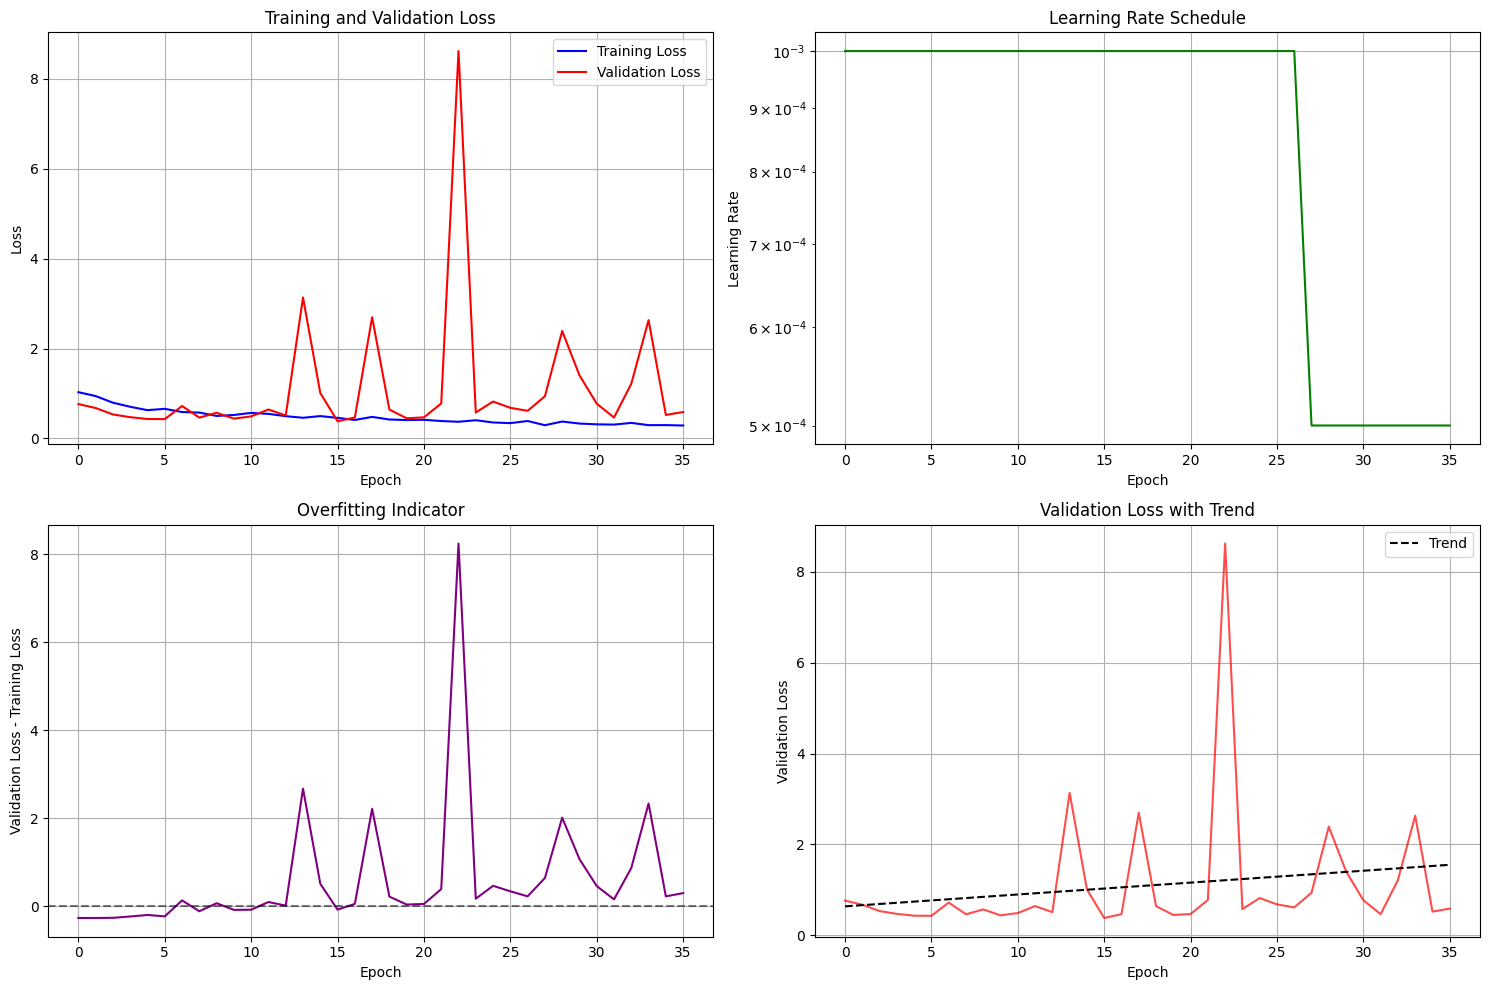

In [111]:
# Evaluate model on test set
print("\nEvaluating model on test set...")
evaluation_results = evaluate_model(
    model=trained_model,
    data_loader=test_loader,
    dataset=train_dataset,  # For normalization parameters
    fpbase_dataset=dataset,
    target_name='ex_max'
)

# Plot training history
plot_training_history(train_losses, val_losses, learning_rates)
